A cycling website I use, https://www.strava.com/dashboard, has both a social aspect to it (free) and a performance aspect (subscription required). I currently have a subscription, but Strava does not have all the analysis tools and statistics I want, so I decided to compute those quantities myself. (There are other websites and applications that can do more sophisticated analyses, but they often are not free, do have as a nice of an interface, and do not have a social aspect.) By doing this I can get exactly what I want on the performance side of things, while still having the social aspect, but now it could be free.

Threshold Power is the power output at which lactic acid starts to build up in a person's body, and thus is an important quantity to know for an endurance athlete. It can be determined through blood testing in a lab. However this can be expensive. An alternative is to do a field test, i.e. go for a bike ride, for Functional Threshold Power (FTP). An FTP test involves doing an eight minute or twenty minute all-out, but steady effort. The athlete's FTP is then given by dividing the average power during this time by 1.10 or 1.05, respectively. That is the twenty minute test tends to overestimate a rider's FTP by five percent, and similarly for the eight minute test.

I recently conducted an FTP test. However, for lack of a better option, the course I chose had a small hill on it. This made it difficult to output a constant power, which is what the test requires. The FTP test is based off of the average power recorded during the test. In cycling, as is the case with so many other things, the average of a quantity does not usually tell the full story. Normalized power, https://www.trainingpeaks.com/blog/what-is-normalized-power/, attempts to take variants in intensity into account. If my normalized power was drastically different from my average power during the test(s), it might indicate that I did not make a good choice for the course. Here is my dilemma, Strava only gives the Normalized Power (they call it Weighted Avg Power) for the whole ride, and won't compute it for part of a ride, which is what I need.

In [1]:
from lxml import etree
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt

%matplotlib notebook

# Data Wrangling and Cleaning

In [3]:
columnlabels = ['Time',
                'Altitude (m)',
                'Distance (m)',
                'Heart Rate (bpm)',
                'Cadence (rev/min)',
                'Speed (m/s)',
                'Power (W)']

In [4]:
def CreateSeries(child):
    """creates a series of data whose properties are given in columnlabels
    return nan if some (cadence, speed, or power) data is missing for a particular child"""
    basicdata = [child.getchildren()[0].text,
                 child.getchildren()[2].text,
                 child.getchildren()[3].text,
                 child.getchildren()[4].getchildren()[0].text]
    
    if len(child.getchildren()) == 5:
        trackdata = (basicdata + 
                     [np.nan]*3)
    elif len(child.getchildren()) == 6:
        trackdata = (basicdata + 
                     [child.getchildren()[5].text] + 
                     [np.nan]*2)
    else:
        trackdata = (basicdata +
                     [child.getchildren()[5].text] + 
                     [extchild.text for extchild in child.getchildren()[6].getchildren()[0].getchildren()])
        
    return pd.Series(dict(zip(columnlabels, trackdata)))

In [5]:
def CreateDataFrame(tracks, i):
    """i is the index of the track in tracks for which the dataframe is to be made"""
    df = pd.DataFrame([CreateSeries(child) for child in tracks[i].getchildren()])
    df['Lap'] = i+1
    return df

In [6]:
def TCXFileToDataFrame(tcxFile, units='Default'):
    """Imports a .tcx file, which is essientially a .xml file, with schema (supposedly) available at http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2.
    Returns a Pandas DataFrame with information from a ride (cycling) from which the .tcx file was created."""
    
    #import .tcx file
    tree = etree.parse(tcxFile)
    root = tree.getroot()
    
    #Track is the keyword we're looking for. To also get the aggregation done by Garmin use Lap instead.
    tracks = root.findall('.//{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Track')
    
    #create the data frame on a per-lap basis
    ldf = [CreateDataFrame(tracks, i) for i in range(len(tracks))]
    
    #merge the lap data frames together
    df = ldf[0]
    for i in range(1, len(ldf)):
        df = pd.merge(df, ldf[i], how='outer')
        
    #clean up the time
    df['Time Elapsed (s)'] = [int(time[11:13])*60**2 + int(time[14:16])*60 + int(time[17:19]) for time in df['Time']]
    df['Time Elapsed (s)'] -= min(df['Time Elapsed (s)'])
    #set elapsed time as index
    #and replace missing (altitude, distance, heart rate) data with NaN
    df = (df.set_index('Time Elapsed (s)')
          .drop('Time', 1)
          .replace({"\n              ":np.nan,
                    "\n                ":np.nan}))
    
    #.tcx is parsed as strings, convert to numeric values
    df = df.iloc[:].apply(pd.to_numeric)
    
    #convert units -- optional input
    if units == 'Imperial':
        df['Altitude (m)'] *= 3.28084 # ft / m
        df['Distance (m)'] /= 1609.34 # m / mi
        df['Speed (m/s)'] *= 2.23694 # mph / (m/s)
        df = df.rename(columns={'Altitude (m)':'Altitude (ft)',
                                'Distance (m)':'Distance (mi)',
                                'Speed (m/s)':'Speed (mph)'})
    if units == 'Metric':
        df['Distance (m)'] /= 1000 # m / km
        df['Speed (m/s)'] *= 3.6 # (km/h) / (m/s)
        df = df.rename(columns={'Distance (m)':'Distance (km)',
                                'Speed (m/s)':'Speed (km/h)'})
    
    return df

# Exploratory Analysis and Preprocessing

In [7]:
tcxdf = TCXFileToDataFrame('activity_1842583687.tcx', units='Imperial')

What do the data look like?

In [8]:
tcxdf.loc[2400:2410]

,Altitude (ft),Cadence (rev/min),Distance (mi),Heart Rate (bpm),Power (W),Speed (mph),Lap
Time Elapsed (s),,,,,,,
2400,319.553821,95.0,11.011023,193.0,238.0,24.557127,2
2401,319.553821,96.0,11.017988,193.0,242.0,24.559364,2
2402,319.553821,96.0,11.024811,193.0,287.0,24.534759,2
2403,319.553821,96.0,11.031790,193.0,249.0,24.787533,2
2404,319.553821,97.0,11.038761,194.0,246.0,24.838982,2
2405,319.553821,97.0,11.045590,194.0,203.0,24.496730,2
2406,319.553821,97.0,11.052630,194.0,206.0,24.570549,2
2407,319.553821,95.0,11.059397,194.0,224.0,24.541468,2
2408,319.553821,97.0,11.066356,193.0,229.0,24.568312,2


Raw data, recorded every second, can be too noisey sometimes. Average over various time intervals when necessary.

In [9]:
def getNsecondaverage(n):
    df = pd.DataFrame([tcxdf.reset_index().iloc[n*i:n*(1+i)].mean() for i in range(int(len(tcxdf)/n))])
    return df.rename(columns=dict(zip(tcxdf.columns, [name[:5] + ' ' + str(n) + 's' for name in tcxdf.columns])))

In [10]:
df3 = getNsecondaverage(3)

In [11]:
df10 = getNsecondaverage(10)

In [12]:
df60 = getNsecondaverage(60)

My Garmin cycling computer appears to only be able to determine the relative altitude. I know this because the two valleys at the beginning of the ride are at or below sea level. Perhaps the temperature or other conditions affected its performance in this area.

This also makes it clear that there was a small hill on the course I choose to do my FTP test.

<IPython.core.display.Javascript object>


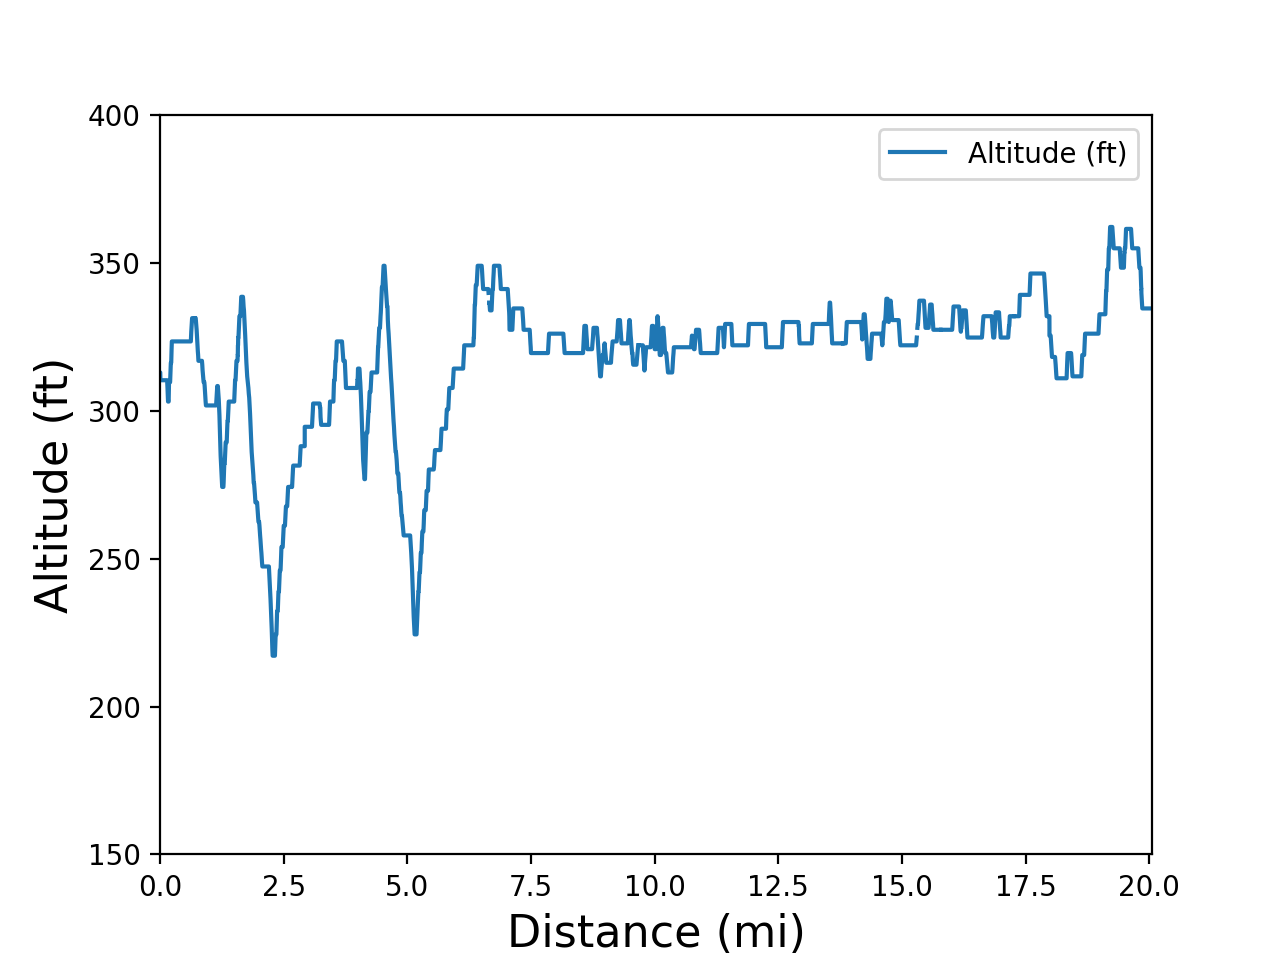

In [13]:
ax = tcxdf.plot(x='Distance (mi)', y='Altitude (ft)', kind='line', ylim=[150, 400]);
ax.set_xlabel(r"Distance (mi)", fontsize=16);
ax.set_ylabel(r"Altitude (ft)", fontsize=16);

The power data are noisey, so I plotted various time-averages instead. I did two eight minutes tests, which are clear in this data.

In [14]:
def plotPower():
    df = (pd.merge(pd.merge(df3, df10, how='outer', left_on='Time Elapsed (s)', right_on='Time Elapsed (s)'), 
                   df60, how='outer', left_on='Time Elapsed (s)', right_on='Time Elapsed (s)'))
    
    df['Time Elapsed (s)'] /= 60 # convert seconds to minutes
    df = df.rename(columns={'Time Elapsed (s)':'Time Elapsed (min)'})
    
    ax = df.plot('Time Elapsed (min)', ['Power 3s', 'Power 10s', 'Power 60s'])
    
    ax.set_title(r"Time-Averaged Power", fontsize=14)
    ax.set_xlabel(r"Time (min)", fontsize=16)
    ax.set_ylabel(r"Power (W)", fontsize=16)

<IPython.core.display.Javascript object>


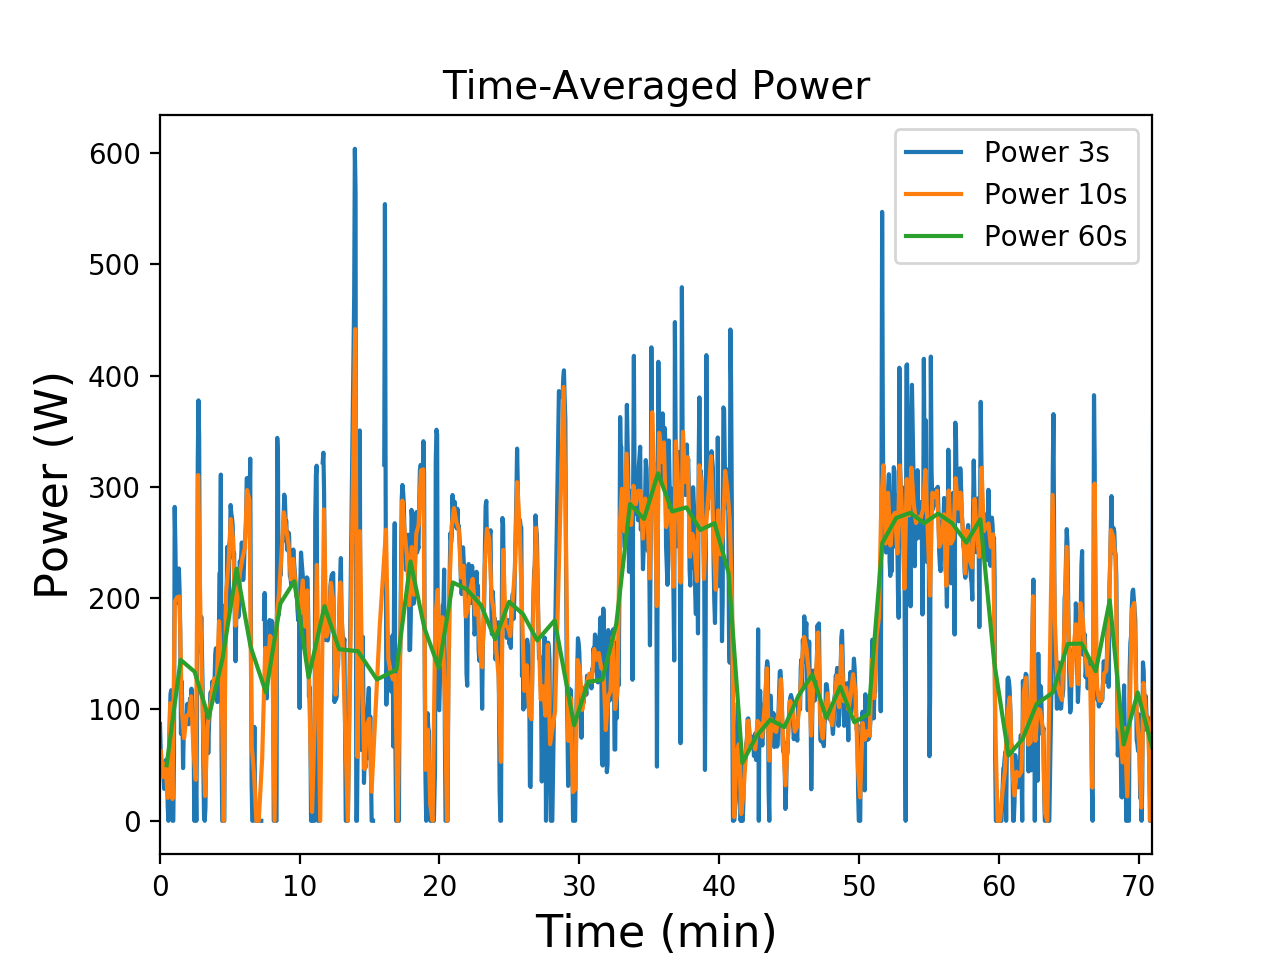

In [15]:
plotPower()

There do not seem to be any real standout features in the cadence data. With that being said, my cadence seems somewhat more consistent during the FTP tests.

In [16]:
def PlotCadence():
    df = tcxdf[(np.isnan(tcxdf['Cadence (rev/min)']) == False) & (tcxdf['Cadence (rev/min)'] >= 20)]
    
    ax = df.plot(x='Distance (mi)', y='Cadence (rev/min)', kind='line', ylim=[50, 130])
    
    ax.set_xlabel(r"Distance (mi)", fontsize=16)
    ax.set_ylabel(r"Cadence (rev/min)", fontsize=16)

<IPython.core.display.Javascript object>


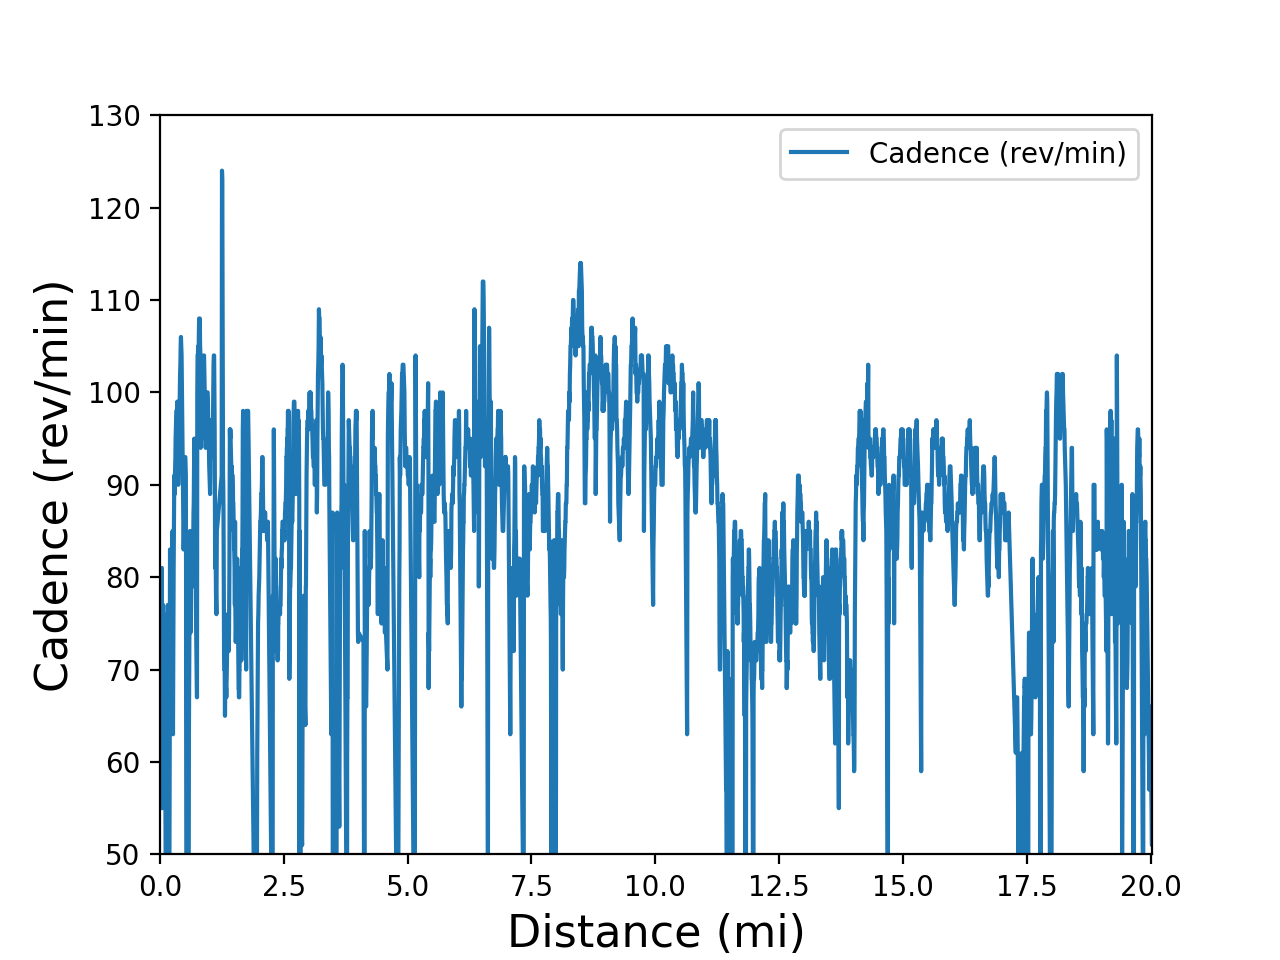

In [17]:
PlotCadence()

The FTP tests are a bit more apparent in the speed data.

<IPython.core.display.Javascript object>


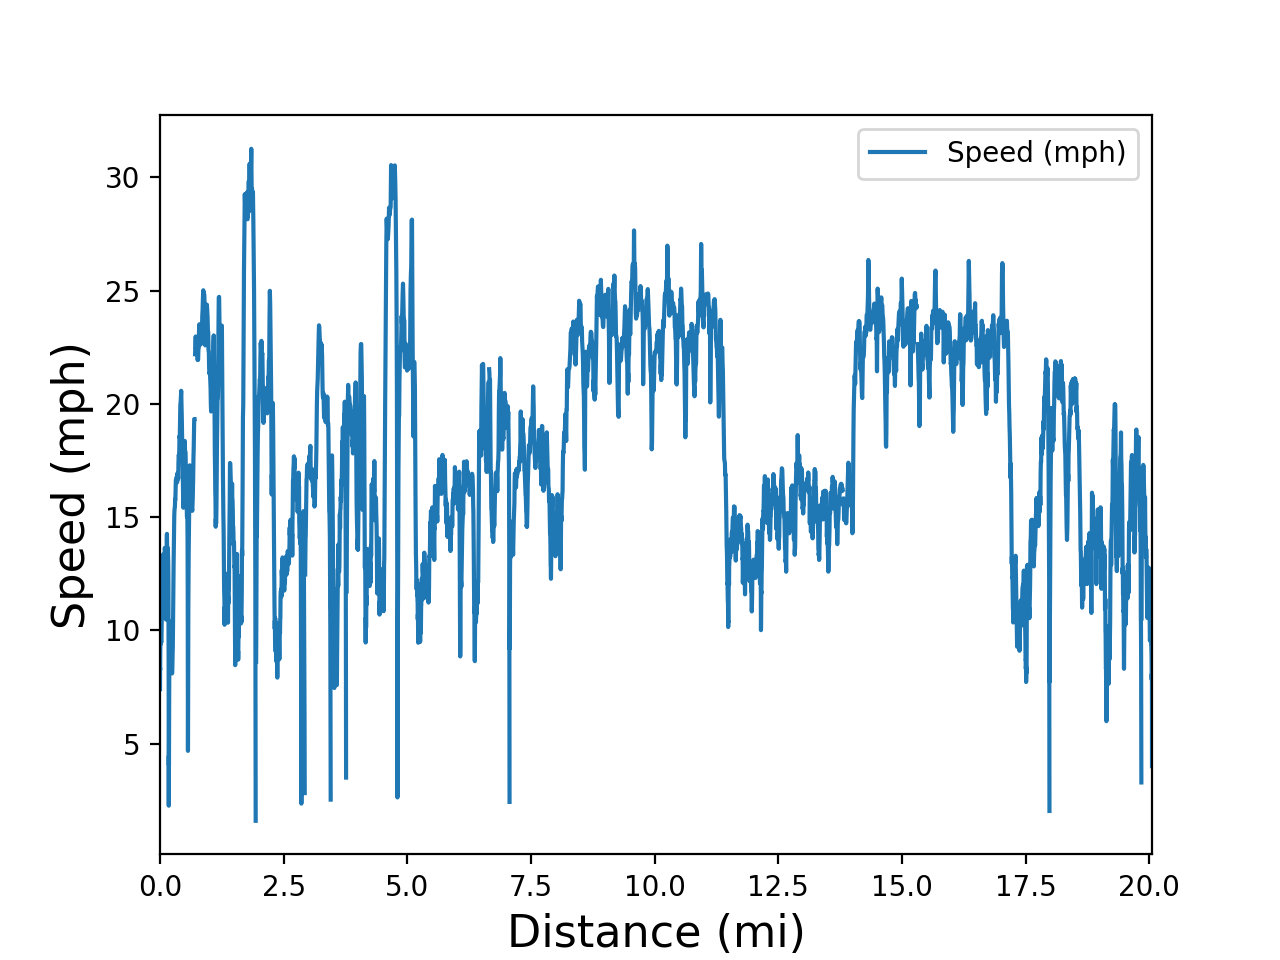

In [18]:
ax = tcxdf.plot(x='Distance (mi)', y='Speed (mph)', kind='line');
ax.set_xlabel(r"Distance (mi)", fontsize=16);
ax.set_ylabel(r"Speed (mph)", fontsize=16);

Lastly, the FTP test really jump out in the heart rate data!

<IPython.core.display.Javascript object>


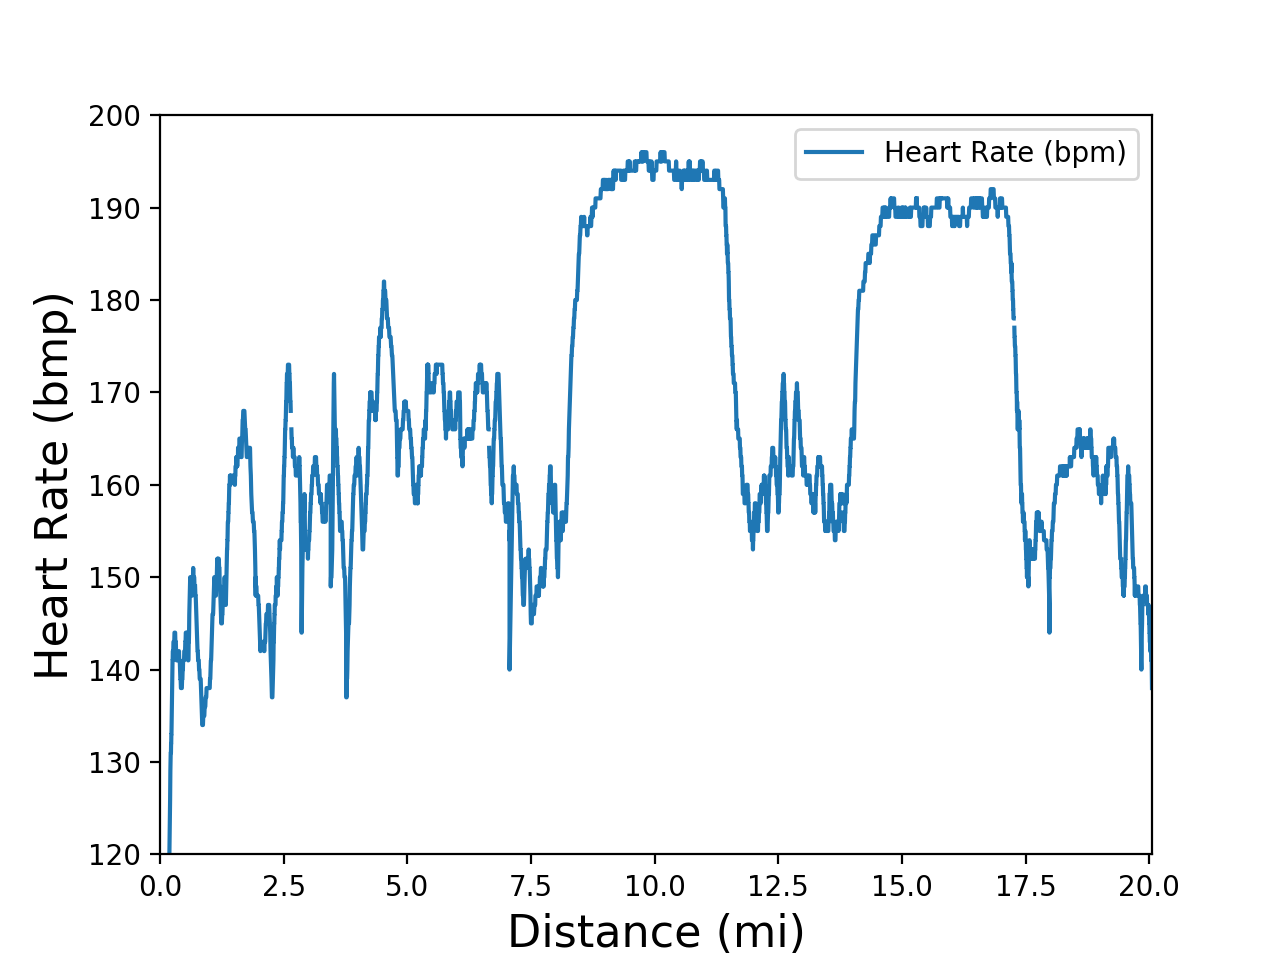

In [19]:
ax = tcxdf.plot(x='Distance (mi)', y='Heart Rate (bpm)', kind='line', ylim=[120, 200]);
ax.set_xlabel(r"Distance (mi)", fontsize=16);
ax.set_ylabel(r"Heart Rate (bmp)", fontsize=16);

# Validation

Compare the average power and the normalized power for the whole ride against what Strava computes, which is available at https://www.strava.com/activities/1073752332. I also compare the average power per lap against what Strava finds.

The only time Strava computes normalized power is for the ride as a whole. That is not what I need. An explicit algorithm for computing normalized power is available here, https://www.mathworks.com/matlabcentral/cody/problems/3064-cycling-normalized-power.

Overall the agreement is good!

In [20]:
avgpower = np.nanmean(tcxdf['Power (W)'])

The average power during my ride was {{ avgpower }} Watts.

In [21]:
normpower = np.average([np.nanmean(tcxdf['Power (W)'].iloc[i:i+30])**4 for i in range(len(tcxdf)-30)])**(1/4)

The normalized power during my ride was {{ normpower }} Watts.

In [22]:
def lappower(lap):
    return np.nanmean(tcxdf[tcxdf['Lap']==lap]['Power (W)'])

The average power on lap 1 was {{ lappower(1) }} Watts.  
The average power on lap 2 was {{ lappower(2) }} Watts.  
The average power on lap 3 was {{ lappower(3) }} Watts.  
The average power on lap 4 was {{ lappower(4) }} Watts.  
The average power on lap 5 was {{ lappower(5) }} Watts.  

# Analysis

In [23]:
def dfAggregate(df):
    """given a data frame with cycling data from .tcx file
    return the per lap average cadence, heart rate, power, and speed 
    as well as the distance traveled on that lap"""
    return (df.dropna()
          .groupby('Lap')
          .agg({'Cadence (rev/min)':np.average,
                'Distance (mi)':np.ptp,
                'Heart Rate (bpm)':np.average,
                'Power (W)':np.average,
                'Speed (mph)':np.average})
            .rename(columns={'Distance (mi)':'Distance Traveled (mi)',
                             'Cadence (rev/min)':'Average Cadence (rev/min)',
                             'Heart Rate (bpm)':'Average Heart Rate (bpm)',
                             'Power (W)':'Average Power (W)',
                             'Speed (mph)':'Average Speed (mph)'}))

In [24]:
tcxaggdf = dfAggregate(tcxdf)

In [25]:
def getNormalizedPower(df, lap):
    """returns the normalized power for a given lap"""
    dflap = (df[df['Lap']==lap]
             .dropna())
    # computer a 30 second rolling average of the power
    # and raise it to the 4th power
    powerRollingAverage4 = [np.mean(dflap['Power (W)'].iloc[i:i+30])**4 for i in range(len(dflap)-30)]
    
    return np.average(powerRollingAverage4)**(1/4)

In [26]:
tcxaggdf['Normalized Power (W)'] = [getNormalizedPower(tcxdf, lap) for lap in tcxdf['Lap'].unique()]

To my surprise(!) the normalized power and average power are nearly identical during each of my tests, laps 2 and 4. Hey, at least now I know.

In [27]:
tcxaggdf

,Average Cadence (rev/min),Distance Traveled (mi),Average Heart Rate (bpm),Average Power (W),Average Speed (mph),Normalized Power (W)
Lap,,,,,,
1,73.078270,8.237004,156.564860,158.105638,15.706884,187.368815
2,95.149160,3.130743,191.628151,280.886555,23.072109,281.861606
3,70.848532,2.686449,162.701700,99.434312,14.900492,109.532619
4,87.811321,3.067928,188.668763,268.268344,22.766276,269.809524
5,62.804709,2.933600,158.516620,105.768698,14.132392,139.129332


Does the rolling average matter? It seems to make a 15-25 Watts difference.

In [28]:
def getNormalizedPower4(df, lap):
    """returns the analog normalized power for the case where a rolling average is not taken for a given lap"""
    dflap = (df[df['Lap']==lap]
             .dropna())
    #raise it to the 4th power
    dflap['Power**4'] = dflap['Power (W)']**4
    
    return np.average(dflap['Power**4'])**(1/4)

In [29]:
[getNormalizedPower4(tcxdf, lap) for lap in tcxdf['Lap'].unique()]

[230.96131408721075,
 308.45734372367559,
 172.94202728463071,
 285.85182830014401,
 177.99341406239313]

Does the fourth power (and root) matter? Try the second power instead, and try both with and without the rolling average. This may be more intuitive this quantity will be related to the standard deviation of the power on a given lap. At least, without the rolling average this also seems to make a difference.

In [30]:
def getNormalizedPower2(df, lap):
    """returns the 'normalized power' for a given lap, using the 2nd power instead of 4th and w/o a rolling average"""
    dflap = (df[df['Lap']==lap]
             .dropna())
    # and raise it to the 2nd power
    dflap['Power**2'] = dflap['Power (W)']**2
    
    return np.average(dflap['Power**2'])**(1/2)

In [31]:
[getNormalizedPower2(tcxdf, lap) for lap in tcxdf['Lap'].unique()]

[187.53663243683118,
 291.95007199487918,
 116.43538715425812,
 275.11606089097694,
 134.14206200064146]

In [32]:
def getNormalizedPower2w(df, lap):
    """returns the normalized power for a given lap"""
    dflap = (df[df['Lap']==lap]
             .dropna())
    # computer a 30 second rolling average of the power
    # and raise it to the 2nd power
    powerRollingAverage4 = [np.mean(dflap['Power (W)'].iloc[i:i+30])**2 for i in range(len(dflap)-30)]
    
    return np.average(powerRollingAverage4)**(1/2)

In [33]:
[getNormalizedPower2w(tcxdf, lap) for lap in tcxdf['Lap'].unique()]

[170.12675044097637,
 280.49314003976502,
 101.05249100903946,
 268.98878439398533,
 121.26534899438872]